<a href="https://colab.research.google.com/github/KennetJRamirez/Algoritmos-Geneticos/blob/main/AlgoritmosGeneticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipysheet

**Carga de CSV y Modificacion**

In [ ]:
# Configuracion del entorno (Widgets)
from google.colab import output
output.enable_custom_widget_manager()

import ipysheet
from IPython.display import display

Activamos y solicitamos los widgets necesarios de google colab para el trabajo de la hoja csv funcione correctamente



In [ ]:
# Ingreso de Grafo
sheet = ipysheet.sheet(rows=10, columns=8)  # 9 filas de datos + encabezado

encabezados = ['Arista', 'TipoArista', 'NodoOrigen', 'NodoDestino', 'CapacidadMinima', 'CapacidadMaxima', 'FlujoEntrada', '%']
for col, nombre in enumerate(encabezados):
    ipysheet.cell(0, col, nombre)

# Crear celdas vacías editables para que las llenes manualmente
for row in range(1, 10):  # Filas 1 a 9
    for col in range(8):  # Usar 8 columnas
        ipysheet.cell(row, col, '')

# Mostrar la hoja visual
display(sheet)

Se crea una hoja editable de n columas y n filas para el ingreso de la info de grafo, tales como:


*   Arista
*   TipoArista
*   NodoOrigen
* Nodo Destino
*Capacidad Minima
*Capacidad Maxima
*FlujoEntrada
*%



In [ ]:
# Guardar formato .csv
df = ipysheet.to_dataframe(sheet)

# Reemplazar valores vacíos con NaN para evitar problemas con el CSV
df = df.fillna('')

# Guardar el archivo CSV
df.to_csv('datos_llenos.csv', index=False)

# Mostrar como tabla abajo
df

Se toma lo que se ingreso en la hoja y se guarda en un archivo .csv, para poder usarlo más adelante. Tambien se muestra la tabla justo debajo para ver el resumen de lo ingresado de forma textual.

In [ ]:
# Descargar csv editado
from google.colab import files

files.download('datos_llenos.csv')

Se descaarga al equipo local una copia del csv


<h1> Cargando Datos CSV sin Interfaz Grafica</h1>

In [265]:
# Subir de mis documentos
import csv

with open('datos_llenos.csv', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)  # Saltar fila 'A','B',...
    next(reader)  # Saltar encabezado real

    for row in reader:
        print(row)

['a1', 'Entrada', 'n1', 'n2', '', '', '500', '%']
['a2', '', 'n2', 'n3', '25', '750', '', '%']
['a3', '', 'n3', 'n4', '10', '720', '', '%']
['a4', 'Salida', 'n4', 'n5', '15', '1000', '', '%']
['a5', '', 'n7', 'n2', '7', '414', '', '%']
['a6', '', 'n7', 'n4', '8', '416', '', '%']
['a7', 'Entrada', 'n6', 'n7', '', '', '200', '%']
['a8', '', 'n7', 'n8', '5', '410', '', '%']
['a9', 'Salida', 'n8', 'n9', '9', '1000', '', '%']


Este permite poder leer el contenido del CSV directamente parseado en base a la eliminacion de los encabezados y carga por medio del widget de colab

<h1>Graficando el Grafo</h1>

<ipython-input-266-a5d944b01d6d>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


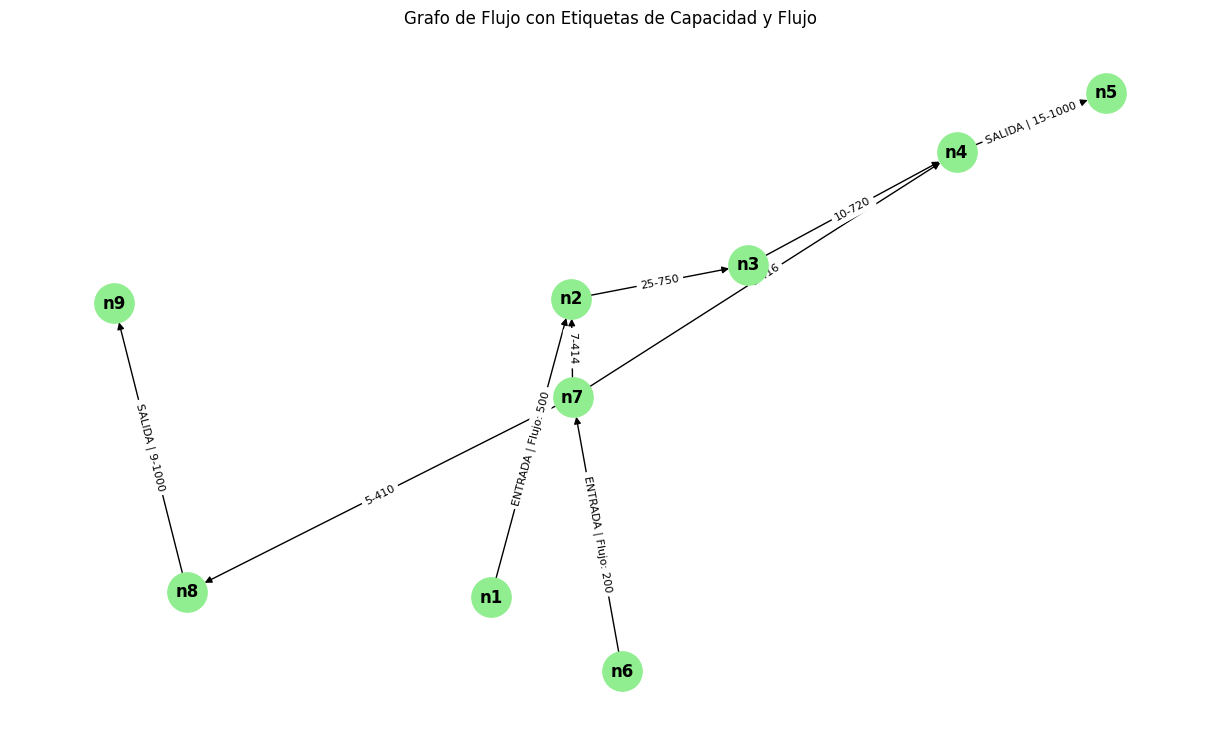

In [266]:
import csv
import networkx as nx
import matplotlib.pyplot as plt

# Leer CSV
aristas = []
with open('datos_llenos.csv', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader)  # Saltar fila A,B,C
    next(reader)  # Saltar encabezados
    for row in reader:
        aristas.append(row)

# Crear grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas con etiquetas
for fila in aristas:
    arista = fila[0]
    tipo = fila[1].strip()
    origen = fila[2].strip()
    destino = fila[3].strip()
    cap_min = fila[4].strip()
    cap_max = fila[5].strip()
    flujo = fila[6].strip()

    etiqueta = []

    if tipo:
        etiqueta.append(tipo.upper())
    if cap_min or cap_max:
        etiqueta.append(f"{cap_min or '0'}-{cap_max or '∞'}")
    if flujo:
        etiqueta.append(f"Flujo: {flujo}")

    label = " | ".join(etiqueta)

    G.add_edge(origen, destino, label=label)

# Dibujar grafo
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 7))
nx.draw(G, pos, with_labels=True, node_size=800, node_color='lightgreen', arrows=True, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['label'] for u, v, d in G.edges(data=True)}, font_size=8)
plt.title("Grafo de Flujo con Etiquetas de Capacidad y Flujo")
plt.axis('off')
plt.tight_layout()
plt.show()


Aca se toma el csv cargado en el paso anterior y se grafica el grafo dirigido. Cada arista muestra informacion como:
* Tipo
* Capacidad Minima - Maxima
* Flujo


**ALGORITMO GENETICO**

In [267]:
# Import de Librerias y Modulos
import csv
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [268]:
NUM_GENERACIONES = 100 # Cantidad Total de Generaciones
EFICIENCIA_OBJETIVO = 0.999 # Representa el valor de la eficiencia que deseamos alcanzar (0.999)
NUM_INDIVIDUOS = 100 # Numero de soluciones presentes en la poblacion en cada generacion
PROB_MUTACION = 0.6 # La posibilidad que el inviduo sufra una mutacion durante la reproduccion
TORNEO_K = 5 # Cantidad de individuos a competir por ser padres , solo se toman los  mejores
MAX_CONVERGENCE = 20 # Cantidad de generaciones seguidas habran hasta que llegue un buen flujo, de lo contrario se termina alli

mejor_flujo_global = 0.0 # Guardar el mejor flujo
generaciones_sin_mejora = 0 # Muestra la cantidad en las generacines que no muestra mejora

In [269]:
def cargar_grafo_csv_unico(path):
    """
    Carga un grafo a partir de un archivo CSV.

    Este grafo está representado como un diccionario que contiene información sobre los nodos,
    las aristas, las entradas y las salidas del grafo. Cada nodo tiene conjuntos de aristas entrantes
    y salientes, y cada arista tiene datos como el origen, destino, capacidad y porcentaje mínimo.

    Parámetros:
    path (str): Ruta del archivo CSV que contiene los datos del grafo.

    Retorna:
    dict: Un diccionario que representa el grafo con nodos, aristas, entradas y salidas.
    """

    # Inicializa un diccionario que va a contener la estructura del grafo
    grafo = {
        "nodes": defaultdict(lambda: {"entrantes": set(), "salientes": set()}),  # Nodos con aristas entrantes y salientes
        "aristas": {},  # Almacena la información de las aristas
        "entradas": [],  # Lista de aristas de entrada
        "salidas": []    # Lista de aristas de salida
    }

    # Abre el archivo CSV y comienza a leerlo
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader, None)  # Salta la primera fila (encabezado)
        next(reader, None)  # Salta la segunda fila (encabezado)

        # Recorre cada fila del archivo CSV
        for row in reader:
            # Si la fila no tiene suficientes datos o el ID de la arista está vacío, se omite
            if len(row) < 6 or not row[0].strip():
                continue

            # Extrae y limpia los datos de la fila
            arista_id = row[0].strip()  # ID de la arista
            origen = row[2].strip()     # Nodo de origen
            destino = row[3].strip()    # Nodo de destino

            # Intenta convertir el porcentaje mínimo y la capacidad a números flotantes
            try:
                min_porcentaje = float(row[4].strip())
            except:
                min_porcentaje = 0.0  # Si no se puede convertir, usa 0.0

            try:
                capacidad = float(row[5].strip())
            except:
                capacidad = 0.0  # Si no se puede convertir, usa 0.0

            # Agrega la información de la arista al diccionario de aristas
            grafo["aristas"][arista_id] = {
                "origen": origen,
                "destino": destino,
                "min_porcentaje": min_porcentaje,
                "capacidad": capacidad
            }

            # Agrega la arista a los conjuntos de salientes del origen y entrantes del destino
            grafo["nodes"][origen]["salientes"].add(arista_id)
            grafo["nodes"][destino]["entrantes"].add(arista_id)

    # Recorre las aristas para identificar las entradas y salidas del grafo
    for arista_id, datos in grafo["aristas"].items():
        origen = datos['origen']
        destino = datos['destino']

        # Si un nodo no tiene aristas entrantes, se considera una entrada
        if not grafo["nodes"][origen]["entrantes"]:
            grafo["entradas"].append(arista_id)

        # Si un nodo no tiene aristas salientes, se considera una salida
        if not grafo["nodes"][destino]["salientes"]:
            grafo["salidas"].append(arista_id)

    # Retorna el grafo completo con nodos, aristas, entradas y salidas
    return grafo

In [270]:
def generar_camino_aleatorio(grafo):
    """
    Genera un camino aleatorio en el grafo a partir de las aristas de entrada.

    La función selecciona una arista de entrada aleatoria y sigue un camino aleatorio
    a través de las aristas salientes del destino de la arista anterior, evitando
    visitar los mismos nodos y aristas más de una vez.

    Parámetros:
    grafo (dict): El grafo representado como un diccionario con nodos y aristas.

    Retorna:
    list: Una lista con las aristas que forman el camino aleatorio.
    """
    camino, aristas_visitadas, nodos_visitados = [], set(), set()
    actuales = list(grafo["entradas"])  # Empieza desde las aristas de entrada
    if not actuales:
        return camino  # Si no hay entradas, retorna un camino vacío
    arista = random.choice(actuales)  # Selecciona una entrada aleatoria

    while True:
        if arista in aristas_visitadas:  # Si la arista ya fue visitada, termina
            break
        camino.append(arista)
        aristas_visitadas.add(arista)

        destino = grafo["aristas"][arista]["destino"]  # Obtiene el destino de la arista
        if destino in nodos_visitados:  # Si el nodo ya fue visitado, termina
            break
        nodos_visitados.add(destino)

        siguientes = [
            a for a in grafo["nodes"][destino]["salientes"]
            if grafo["aristas"][a]["destino"] not in nodos_visitados  # Solo toma aristas no visitadas
        ]
        if not siguientes:  # Si no hay más aristas para seguir, termina
            break
        arista = random.choice(siguientes)  # Elige una arista saliente aleatoria

    return camino


def calcular_flujo(camino, grafo):
    """
    Calcula el flujo total de un camino, considerando las capacidades mínimas
    de cada arista en el camino.

    Parámetros:
    camino (list): Una lista con las aristas que forman el camino.
    grafo (dict): El grafo representado como un diccionario con nodos y aristas.

    Retorna:
    float: El flujo total del camino.
    """
    return sum(grafo["aristas"][a]["capacidad"] * grafo["aristas"][a]["min_porcentaje"] / 100 for a in camino)


def seleccion(poblacion, fitness):
    """
    Realiza una selección por torneo de los individuos en la población según su fitness.

    Parámetros:
    poblacion (list): Lista de individuos (camino) a seleccionar.
    fitness (list): Lista de valores de fitness asociados a cada individuo.

    Retorna:
    list: Una lista de individuos seleccionados para la siguiente generación.
    """
    seleccionados = []
    for _ in range(len(poblacion) // 2):
        torneo = random.sample(list(zip(poblacion, fitness)), TORNEO_K)  # Selecciona un torneo aleatorio
        ganador = max(torneo, key=lambda x: x[1])  # Elige al individuo con mejor fitness
        seleccionados.append(ganador[0])  # Agrega el ganador a la lista de seleccionados
    return seleccionados


def cruzar(p1, p2):
    """
    Cruza dos individuos (caminos) para generar un nuevo individuo (camino hijo).

    El cruce se realiza en dos puntos aleatorios, combinando las partes de ambos caminos.

    Parámetros:
    p1 (list): El primer individuo (camino).
    p2 (list): El segundo individuo (camino).

    Retorna:
    list: El camino hijo generado a partir del cruce.
    """
    punto1 = random.randint(0, len(p1)-1)
    punto2 = random.randint(0, len(p2)-1)
    hijo = p1[:punto1] + p2[punto2:]  # Une las partes de ambos caminos
    return list(dict.fromkeys(hijo))  # Elimina duplicados manteniendo el orden


def mutar(individuo, grafo):
    """
    Aplica una mutación a un individuo (camino), alterando una parte del camino.

    La mutación consiste en reemplazar un tramo del camino por un nuevo camino aleatorio.

    Parámetros:
    individuo (list): El camino (individuo) a mutar.
    grafo (dict): El grafo representado como un diccionario con nodos y aristas.

    Retorna:
    list: El camino mutado.
    """
    if len(individuo) < 2:
        return individuo  # Si el camino es muy corto, no se puede mutar
    punto = random.randint(0, len(individuo) - 1)  # Elige un punto aleatorio para la mutación
    nodo_inicio = grafo["aristas"][individuo[punto]]["origen"]  # Obtiene el nodo de inicio
    nuevo_tramo = generar_camino_aleatorio_desde(grafo, nodo_inicio)  # Genera un nuevo tramo aleatorio
    return individuo[:punto] + nuevo_tramo  # Reemplaza la parte mutada en el camino


def generar_camino_aleatorio_desde(grafo, nodo_inicio):
    """
    Genera un camino aleatorio a partir de un nodo de inicio específico.

    La función sigue el mismo procedimiento que `generar_camino_aleatorio`, pero
    empieza desde un nodo dado en lugar de una arista de entrada.

    Parámetros:
    grafo (dict): El grafo representado como un diccionario con nodos y aristas.
    nodo_inicio (str): El nodo desde el cual se inicia el camino.

    Retorna:
    list: Una lista con las aristas que forman el camino aleatorio generado.
    """
    camino, aristas_visitadas, nodos_visitados = [], set(), set()
    actual = nodo_inicio
    while True:
        posibles = list(grafo["nodes"][actual]["salientes"])  # Obtiene las aristas salientes del nodo actual
        if not posibles:
            break  # Si no hay aristas salientes, termina
        arista = random.choice(posibles)  # Elige una arista aleatoria
        if arista in aristas_visitadas:
            break  # Si la arista ya fue visitada, termina
        camino.append(arista)
        aristas_visitadas.add(arista)
        destino = grafo["aristas"][arista]["destino"]  # Obtiene el destino de la arista
        if destino in nodos_visitados:
            break  # Si el destino ya fue visitado, termina
        nodos_visitados.add(destino)
        actual = destino  # Actualiza el nodo actual con el destino

    return camino



In [271]:

def evolucionar(grafo):
    global mejor_flujo_global, generaciones_sin_mejora

    poblacion = [generar_camino_aleatorio(grafo) for _ in range(NUM_INDIVIDUOS)]
    historial = []
    mejor_individuo = None

    for gen in range(NUM_GENERACIONES):
        fitness = [calcular_flujo(ind, grafo) for ind in poblacion]
        max_fitness = max(fitness)
        idx_max = fitness.index(max_fitness)
        mejor_individuo = poblacion[idx_max]

        if max_fitness > mejor_flujo_global + 0.01:
            mejor_flujo_global = max_fitness
            generaciones_sin_mejora = 0
        else:
            generaciones_sin_mejora += 1

        rel = [f / mejor_flujo_global for f in fitness]
        mejor_rel = max(rel)
        historial.append(mejor_rel)

        print(f"Generación {gen}: Mejor flujo = {max_fitness:.3f}, Relativo = {mejor_rel:.3f}")

        if mejor_rel >= EFICIENCIA_OBJETIVO and generaciones_sin_mejora >= 5:
           # print(f" Eficiencia objetivo alcanzada en generación {gen}.\n")
            break

        if generaciones_sin_mejora >= MAX_CONVERGENCE:
           # print(f"Convergencia alcanzada sin mejora en {MAX_CONVERGENCE} generaciones.\n")
            break

        seleccionados = seleccion(poblacion, fitness)
        nueva_poblacion = seleccionados[:10]

        while len(nueva_poblacion) < NUM_INDIVIDUOS:
            p1, p2 = random.sample(seleccionados, 2)
            hijo = cruzar(p1, p2)
            if random.random() < PROB_MUTACION:
                hijo = mutar(hijo, grafo)
            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion

    return historial, mejor_individuo



In [272]:
# Ejecutar
grafo = cargar_grafo_csv_unico("datos_llenos.csv")
historial, mejor_camino = evolucionar(grafo)


Generación 0: Mejor flujo = 438.480, Relativo = 1.000
Generación 1: Mejor flujo = 438.480, Relativo = 1.000
Generación 2: Mejor flujo = 438.480, Relativo = 1.000
Generación 3: Mejor flujo = 438.480, Relativo = 1.000
Generación 4: Mejor flujo = 438.480, Relativo = 1.000
Generación 5: Mejor flujo = 726.960, Relativo = 1.000
Generación 6: Mejor flujo = 726.960, Relativo = 1.000
Generación 7: Mejor flujo = 726.960, Relativo = 1.000
Generación 8: Mejor flujo = 697.980, Relativo = 0.960
Generación 9: Mejor flujo = 697.980, Relativo = 0.960
Generación 10: Mejor flujo = 481.500, Relativo = 0.662
Generación 11: Mejor flujo = 669.000, Relativo = 0.920
Generación 12: Mejor flujo = 726.960, Relativo = 1.000


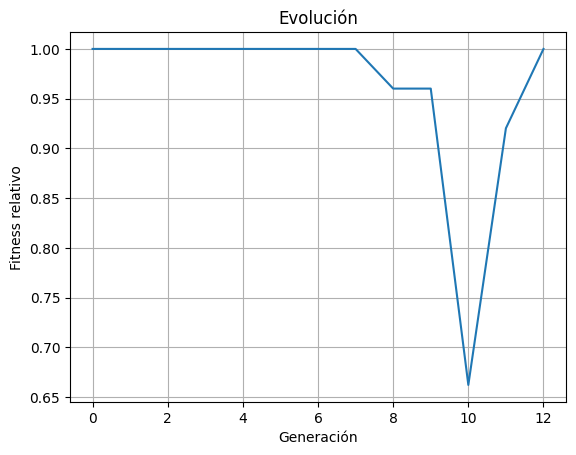

In [273]:
# Graficar Modelo De Evolucion
plt.plot(historial)
plt.title("Evolución")
plt.xlabel("Generación")
plt.ylabel("Fitness relativo")
plt.grid()
plt.show()

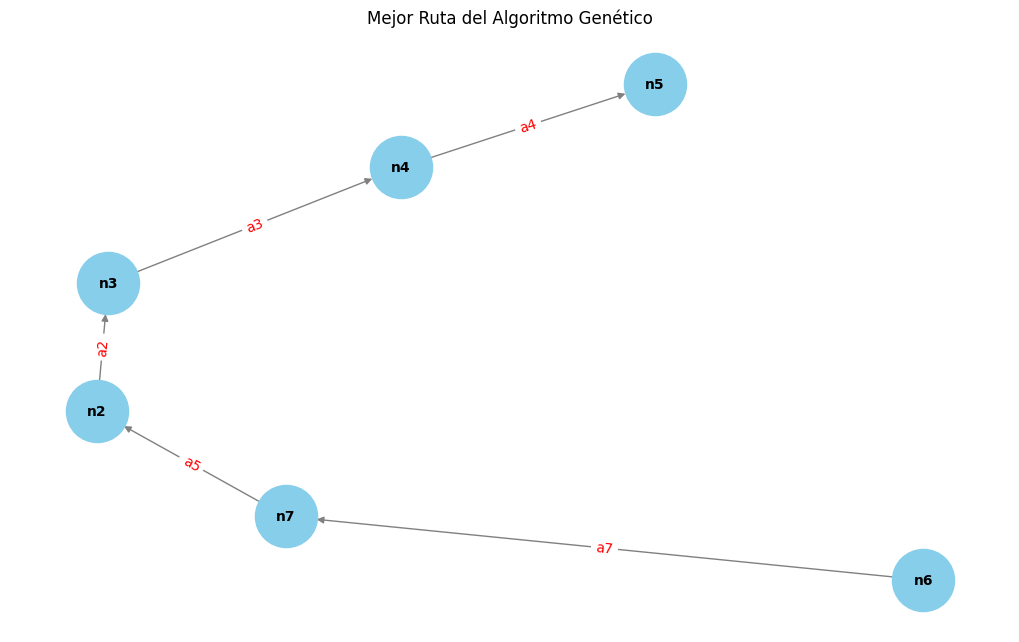

In [274]:

import networkx as nx
import matplotlib.pyplot as plt

# Graficar usando mejor_camino guardado, SIN volver a llamar evolucionar
G = nx.DiGraph()
for arista_id in mejor_camino:
    origen = grafo["aristas"][arista_id]["origen"]
    destino = grafo["aristas"][arista_id]["destino"]
    G.add_edge(origen, destino, label=arista_id)

pos = nx.spring_layout(G, seed=42)
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000,
        font_size=10, font_weight='bold', edge_color="gray", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Mejor Ruta del Algoritmo Genético")
plt.axis("off")
plt.show()